In [1]:
from ipyleaflet import Map, TileLayer, WidgetControl, basemaps
from ipywidgets import IntSlider, jslink
import xarray as xr
# import cartopy.crs as ccrs
%matplotlib inline

In [2]:
import tilecube

In [3]:
ds = xr.tutorial.open_dataset('rasm').load()
ds

<xarray.Dataset>
Dimensions:  (time: 36, y: 205, x: 275)
Coordinates:
  * time     (time) object 1980-09-16 12:00:00 ... 1983-08-17 00:00:00
    xc       (y, x) float64 189.2 189.4 189.6 189.7 ... 17.65 17.4 17.15 16.91
    yc       (y, x) float64 16.53 16.78 17.02 17.27 ... 28.26 28.01 27.76 27.51
Dimensions without coordinates: y, x
Data variables:
    Tair     (time, y, x) float64 nan nan nan nan nan ... 29.8 28.66 28.19 28.21
Attributes:
    title:                     /workspace/jhamman/processed/R1002RBRxaaa01a/l...
    institution:               U.W.
    source:                    RACM R1002RBRxaaa01a
    output_frequency:          daily
    output_mode:               averaged
    convention:                CF-1.4
    references:                Based on the initial model of Liang et al., 19...
    comment:                   Output from the Variable Infiltration Capacity...
    nco_openmp_thread_number:  1
    NCO:                       netCDF Operators version 4.7.9 (Homepage = htt...
    history:                   Fri Aug  7 17:57:38 2020: ncatted -a bounds,,d...

In [4]:
plt.figure(figsize=(14,6))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_global()
ds.Tair[0].plot.pcolormesh(ax=ax, transform=ccrs.PlateCarree(), x='xc', y='yc', add_colorbar=False)
ax.coastlines()
ax.set_ylim([0,90]);


NameError: name 'plt' is not defined

In [5]:
ds['xc'].min(), ds['xc'].max()

(<xarray.DataArray 'xc' ()>
 array(0.00349426),
 <xarray.DataArray 'xc' ()>
 array(359.99980927))

In [6]:
ds['xc'] = ds['xc'] - 180
ds['xc'].min(), ds['xc'].max()

(<xarray.DataArray 'xc' ()>
 array(-179.99650574),
 <xarray.DataArray 'xc' ()>
 array(179.99980927))

In [7]:
ds['xc'][ds['xc'] <= 160]

IndexError: 2-dimensional boolean indexing is not supported. 

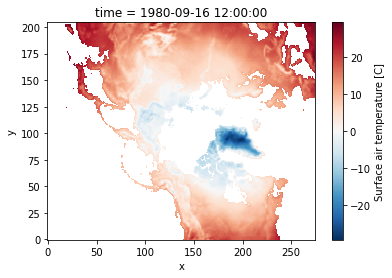

In [8]:
ds['Tair'][0].plot()

In [10]:
m = Map(basemap=basemaps.OpenStreetMap.Mapnik, zoom=0)
layer = TileLayer(url='http://localhost:5000/0/{z}/{x}/{y}.png')
m.add_layer(layer)

def update_time(change):
    url = 'http://localhost:5000/' + str(time_slider.value) + '/{z}/{x}/{y}.png'
    print(url)
    layer.url = url

time_slider = IntSlider(description='Time Step:', min=0, max=2920, value=0)
time_slider.observe(update_time, 'value')
# jslink((time_slider, 'value'), (layer, 'url'))
time_control = WidgetControl(widget=time_slider, position='topright')
m.add_control(time_control) 

m

Map(center=[0.0, 0.0], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', 'zoom_out_t…